In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from numpy import sqrt
from IPython.display import Image
from qutip import *
from qutip.measurement import *

# Experimental test of Bell's inequality
Main references: 
1. Aspect, Dalibard and Roger, "Experimental test of Bell's inequalities using time-varying analyzers," Phys.Rev. Letter 49, 1802, December 1982
2. Clauser and Horne, "Experimental consequences of objective local theories," Phys.Rev.D. 10 (2):536, July 1974
3. Dehlinger and Mitchell, "Entangled photons, nonlocality, and Bell inequalities in the undergraduate laboratory," Am. J. Phys. 70 (9), 904, September 2002

We use Python Qutip to replicate the experiment performed by Alain Aspect and co-workers in 1982 (Ref 1), where for the first time the violation of Bell's inequalies was experimentally demonstrated. The exact formulation of the inequality differs slighly from the original Bell inequality and is also known as the 'CHSH inequality'. The paper by Clauser and Horne (Ref 2) provides background to the exact formulation of the Bell inequality used by Aspect. A lot has been said and written about Bell's inequality, local theories, quantum mechanics, ... a nice overview with a strong link to experimental set-up, history and interpretation is given by Mitchell (Ref 3).

> Modelling components of the experimental set-up
* Entangled photons
* Measuring the quantuam state / detecting the photons
* Polarizers at various orientations
> Analyzing the experimental results
* Analysis as done in the Aspect paper (Ref 1)
* Alternative formulation of CHSH inequality
> Simulating the experiment
> Assessing the simulation results
* Compared to what was found by Aspect
* Including noise
* Without the 'spooky action on a distance'
* Without entanglement
* For different orientations of the polarizers
* For an optimal 'local hidden variable' state



The experiment carried out by Alain Aspect and co-workers is considered the was the first to demonstrate the violation of Bell's inequalities. Here we use Python Qutip to model the setup used by Aspect and to simulate the experimental result obtained. To model the experimental setup we need a few elements:
* entangled photons from source 'S' in Fig2
* detectors to measure correlation (PM1, PM1' at one side and PM2, PM2' at the other side in Fig2)
* polarizers at variable orientation (Ia, Ia' at one side and IIb, IIb' at the other sidein Fig2)

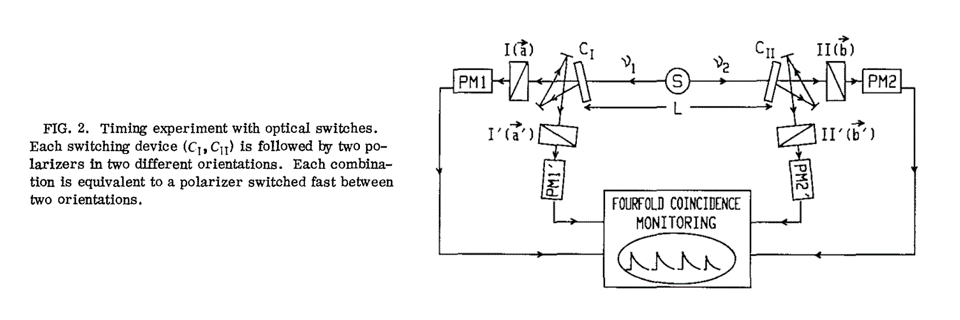

In [80]:
Image(filename='./Fig2 -Aspect-PRL-20dec1982.png')

## Entangled photons
The source generates pairs of photons which are fully entangled in their polarization. This means that once the polarization of one photon is established, the other photon necessarily has the same polarization. In qutip we use a 'quantum object' to set up this state in the basis [|11>],[|10>],[|01>],[|00>]. For simplicity, let's take a '11' to mean that both photons are horizontally polarized (the first '1' representing the first photon and the second '1' representing the second photon). In this case '00' would mean both photons are vertically polarized. The entangled state is then defined as $\frac{1}{\sqrt{2}} * (|11> + |00>)$

In [81]:
x = 1/sqrt(2)
state = Qobj([[x], [0], [0], [x]], dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
print("\nInput state in basis [|11>],[|10>],[|01>],[|00>]\n\n", state)


Input state in basis [|11>],[|10>],[|01>],[|00>]

 Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]


## Detection
We can set up the detectors to detect the two photons in either state '1' (horizontal polarization) or state '0' (vertical polarization). For the initial state $\frac{1}{\sqrt{2}} * (|11> + |00>)$ we expect to find  in 50% of cases both photons in horizontal polarization, and in 50% of cases both in vertical polarization. To check whether we set up qutip right we repeat the measurement 1000 times and store the result in a list ('result') where we count the detection of '11', '10', '01' and '00'. The expectation is to find around 500 counts in '11' and 500 counts in '00', but none in '10' or '01'. Here we first set up qutip for the measurement where Z0 and Z1 are the projectors on state |1> or |0> for an individual photon, and PZ0 is the list of projectors for the first photon while PZ1 is the list of projectors for the second photon.

In [82]:
result = [0,0,0,0]
Number_of_experiments = 1000

#measurement projection for the single photon
Z0 = ket2dm(Qobj([[1], [0]])) # |1><1|
Z1 = ket2dm(Qobj([[0], [1]])) # |0><0|

#measurement projection for first and second photon
PZ0 = [tensor(Z0, identity(2)), tensor(Z1, identity(2))]
PZ1 = [tensor(identity(2), Z0), tensor(identity(2), Z1)]

for i in range(0,Number_of_experiments):
    #measure qubit 0
        value_0, output_state_0 = measure(state, PZ0) 
    #measure qubit 1
        value_1, output_state_1 = measure(output_state_0, PZ1)
    #assess outcome
        r = value_1 + value_0*2
    #print("m:{},r:{}".format(m,r))
        result[r] = result[r] + 1

print('\nResult matrix:\nin form [r11, r10, r01, r00]\n ', result)


Result matrix:
in form [r11, r10, r01, r00]
  [497, 0, 0, 503]


## Rotating polarizers
The detection method used above is projecting the photon states on '1' and '0', meaning horizontal or vertical polarization. To replicate the Aspect experiment we need to be able to measure for polarizations which are not fully aligned to the horizontal or vertical direction, i.e., we need to be able to set the angle of the polarizers in front of the detectors. In order to do so we define a rotation matrix taking angle $\theta$ as input.
 
 $\begin{pmatrix}
  \cos(\theta) & -i \cdot sin(\theta) \\
  -i \cdot sin(\theta) & \cos(\theta) \\
 \end{pmatrix}$

 For $\theta = \pi$  this gives a matrix with only off-diagonal elements, effectively exchanging the horizontal and vertical polarization. 
$\begin{pmatrix}
  0 & -1 \\
  1 & 0 \\
 \end{pmatrix}$
 Note that $\theta = \pi$ corresponds to rotating the polarizer over $90^o$ in the real world. A lot a can be said on the factor two between the angle $\theta$ and the actual rotation of the optical polarizer. We stick to convention of using $\theta$ for rotation on the Bloch sphere (see for instance https://en.wikipedia.org/wiki/Bloch_sphere), so $\theta = \pi/4$ means a polarizer at $22.5^o$, $\theta = \pi/2$ means a polarizer at $45^o$ and $\theta = 3\pi/4$ means a polarizer at $67.5^o$.

In [83]:
def Rotation(Theta):
    rot_y = np.cos(Theta/2) * qeye(2) + np.sin(Theta/2) * (-1j) * sigmay()
    return rot_y

In [84]:
print(Rotation(0))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]


In [85]:
print(Rotation(pi))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0. -1.]
 [ 1.  0.]]


In [86]:
print(Rotation(pi/4))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.92387953 -0.38268343]
 [ 0.38268343  0.92387953]]


## Data analysis to detect violation of Bell's inequalities
### Analysis as done in the Aspect paper
Before simulating the experiment let's look at what result would lead to conclusion that Bell's inequalities are violated, i.e., to the conclusion that we have correlations which cannot be explained by classical physics. The Aspect article uses the CSHS inequality where according to classical theory the parameter $S$ should be limited to $-1 \leq S \leq 0$. In this case $S$ is defined as below, with $N(\vec{a},\vec{b})$ occurence of detecting a photon behind polarizer orientation $\vec{a}$ at one side and $\vec{b}$ at the other side. $N(\infty,\infty)$ represents the detection of two photons with polarizer removed and $N(\vec{a},\infty)$ or $N(\infty,\vec{b})$ represent the detection with the polarizer removed at one side.

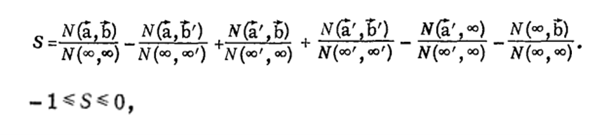

In [87]:
Image(filename='./Quotation2-Aspect-PRL-20dec1982.png')

The situation where we expect maximum violation of Bell's inequality is where polarizer orientations are:
* $a = 0^o, \theta = 0$
* $b = 22.5^o, \theta = \pi/4$
* $a'= 45^o,\theta = \pi/2$
* $b'= 67.5^o,\theta = 3\pi/4$



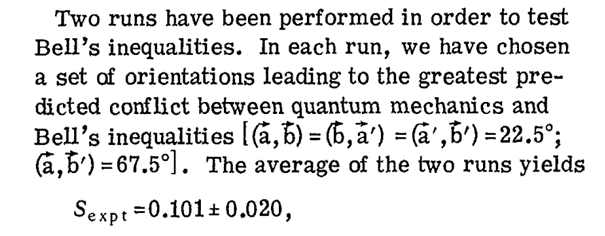

In [88]:
Image(filename='./Quotation-Aspect-PRL-20dec1982.png')

### Alternative formulation of CHSH inequality
The alternative way to express the Bell inequality is given by Clauser and Horne in their 1974 paper ("Experimental consequences of objective local theories", Clauser and Horne, Phys.Rev.D. 10 (2):536 - 535 ). Here for each combination of  a/a' and b/b', the numbers of coincidences in each category $N_{++},N_{--},N_{+-},N_{-+}$ are recorded. So as opposed to what is used in the Aspect paper we do not only use teh occurence of detecting a photon at both sides ($N_{++}$), but also the occurence of the other events. The experimental value of $P(a,b)$ is then calculated as $\frac{N_{++} + N_{--} - N_{+-} -N_{-+}}{N_{++} + N_{--} + N_{+-} + N_{-+}}$. Finally $S$ is derived as $S = P(a,b) - P(a,b') + P(a',b) + P(a',b')$. Note that this is different $S$ than used in the Aspect paper, and Bell inequality translate as $-2 \leq S \leq 2$. Experimentally  this inequality is more difficult to validate, but as computer simulation is obviously straightforward to implement.

As we will use both ways to express the CHSH inequality in the simulation below we will use a subscript to distinguish which $S$ we are talking about. This means the inequality is expressed as  

$-1 \leq S_{Aspect} \leq 0$ 

$-2 \leq S_{CHSH} \leq 2$

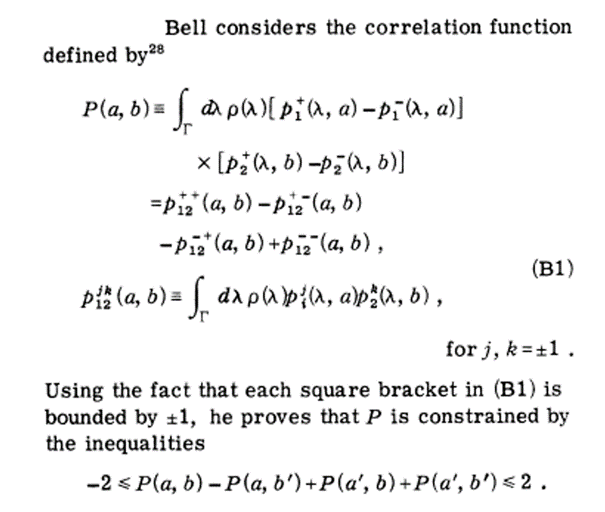

In [89]:
Image(filename='./Quote-Clauser-Horne-july1974.png')

## The experiment
We now have the basics in place. Entangled photons, detectors and polarizers which can be rotated at any angle. For any given choice of polarizers we will detect the occurence of 4 possible outcomes (both sides detect '1', both sides '0' or one side '1' and the other '0'). For each side we randomly select which polarizers to use. Either we use $ab, a'b, ab' or a'b'$. To record the outcome of our experiment we therefore have 4 different alignments of the polarizers, and for each alignment we detect the frequency of 4 different outcomes. We repeat our experiment a number of times and count the occurences. From these occurences we then calculate the value of $S$ either in the way done in the Aspect paper, or in the more recognizable form proposed by Clauser and Horne.

To be able to play a bit with the set-up we create a function to simulate the experiment, taking a few options as input:

* The two-photon state as input written in a 4 dimensional basis. So any state can be represented as $c_{11}|11> + c_{10}|10> + c_{01}|01> + c_{00}|00>$. For maximum entanglement the state we use is $\frac{1}{\sqrt{2}} * (|11> + |00>)$, but we could also use a state without entanglement or a state where the photon polarization is fully defined (not random).

* We have 4 possible alignments of the polarizers, or to phrase differently we can have 4 combinations of the detectors indicated in Fig2 in the Aspect paper. So we have polarization orientation $ab, a'b, ab' or a'b'$, or we have detecors PM1/PM2, PM1'/PMS, PM1/PM2' or PM1'/PM2'. In the function we use a Python 'dict' to capture the four angles. Maximum violation of the Bell inequality we expect for `angles = {'PM1': 0, 'PM1prime': pi/2, 'PM2': pi/4, 'PM2prime': 3*pi/4}`

* The number of repeates we enter as `Number_of_experiments`

* We add a Python `dict` called `noise` to give the option to add a rate for false positive and false negatives at the detectors (simulating a background noise and a less than perfect detector/optical path efficiency).

* Finally we add a boolean called `collapse` to be able to switch on or off the collapse of the wave function. If this boolean is `True` we collapse the two-photon wave function at detection of teh first photon and use the resulting state for detection of the second photon. With this boolean set to `False` we use the original state for the second photon. Effectively we switch of the 'spooky action at a distance' with this parameter.

In [90]:
def Rotation(Theta):
    rot_y = np.cos(Theta/2) * qeye(2) + np.sin(Theta/2) * (-1j) * sigmay()
    return rot_y
    
def Run_Aspect_Experiment(state, angles, Number_of_experiments, noise, collapse):

    # store all correlations with and without polarizer to calculate S_Aspect
    result12 = [0,0,0,0]
    result1 = [0,0,0,0]
    result2 = [0,0,0,0]
    N = [0,0,0,0]

    # store all correlations for all polarizer orientation to calculate S_CHSH
    result = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]

    # create list of random numbers to select which polarizer to use for each measurement
    experiment = np.random.rand(2,Number_of_experiments)

    # measurement projection for the single photon
    Z0 = ket2dm(Qobj([[1], [0]])) # |1><1|
    Z1 = ket2dm(Qobj([[0], [1]])) # |0><0|

    # measurement projection for first and second photon
    PZ0 = [tensor(Z0, identity(2)), tensor(Z1, identity(2))]
    PZ1 = [tensor(identity(2), Z0), tensor(identity(2), Z1)]

    # define the orientation of the polarizers
    PM1 = tensor(Rotation(angles.get('PM1')),identity(2)) 
    PM1prime = tensor(Rotation(angles.get('PM1prime')),identity(2)) 
    PM2 = tensor(identity(2),Rotation(angles.get('PM2'))) 
    PM2prime = tensor(identity(2),Rotation(angles.get('PM2prime'))) 

    for i in range(Number_of_experiments):
        # measure first photon
        if experiment[0,i] > 0.5:
            value_0, output_state_0 = measure(PM1 * state, PZ0) 
            m0 = 0
        else:
            value_0, output_state_0 = measure(PM1prime * state, PZ0)
            m0 = 1
        # wave function collapse
        if collapse == True:
            new_state = output_state_0
        else:
            new_state = state
        # second photon
        if experiment[1,i] > 0.5:
            value_1, output_state_1 = measure(PM2*new_state, PZ1)
            m1 = 0
        else:
            value_1, output_state_1 = measure(PM2prime*new_state, PZ1)
            m1 = 1
        # add noise if boolean add_noise is True. Assume in x% of cases we see false positive 
        # (i.e., detect a photon when non should be there) and assume in y% of cases we fail to detect te photon (due to optical system, detector efficiency)
        if noise.get('add_noise'):
            if value_0 == 0 and np.random.uniform() < noise.get('false_positive'):
                value_0 = 1
            elif value_0 == 1 and np.random.uniform() < noise.get('false_negative'):
                value_0 = 0
            if value_1 == 0 and np.random.uniform() < noise.get('false_positive'):
                value_1 = 1
            elif value_1 == 1 and np.random.uniform() < noise.get('false_negative'):
                value_1 = 0

        # assess outcome. Note that the 'special case' when polarizers are at 67.5degrees is for m0 = 0 and m1 = 1, so m = 2
        m = m1*2 + m0

        # calculate S_Aspect
        # without polarizers
        if (value_0 == 1 or value_0 == 0) and (value_1 == 1 or value_1 == 0): 
            N[m] = N[m] + 1
        #with polarizer in first channel
        if value_0 == 1:
            result1[m] = result1[m] + 1
        #with only polarizer in second channel
        if value_1 == 1:
            result2[m] = result2[m] + 1
        #with polarizers at both sides
        if value_0 == 1 and value_1 == 1:
            result12[m] = result12[m] + 1
        
        # calculate S_CHSH
        r = value_1 + value_0*2
        result[m][r] = result[m][r] + 1

    S_Aspect = result12[0]/N[0] + result12[1]/N[1] - result12[2]/N[2] + result12[3]/N[3] - result1[1]/N[1] - result2[0]/N[0]

    # calculate S_CHSH
    correlate = [0,0,0,0]
    for m in range(0,4):
        if (result[m][0]+result[m][1]+result[m][2]+result[m][3])>0:
            correlate[m] = (result[m][0]-result[m][1]-result[m][2]+result[m][3])/(result[m][0]+result[m][1]+result[m][2]+result[m][3])
        else:
            correlate[m] = 0 #measurements done for this combination of m0 and m1
    
    S_CHSH = correlate[0]+correlate[1]-correlate[2]+correlate[3]    

    return {'S_Aspect': S_Aspect, 'S_CHSH': S_CHSH }

In [91]:
x = 1/sqrt(2)
state = Qobj([[x], [0], [0], [x]], dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
angles = {'PM1': 0, 'PM1prime': pi/2, 'PM2': pi/4, 'PM2prime': 3*pi/4}
Number_of_experiments = 1000
noise = {'add_noise': False, 'false_positive': 0.01, 'false_positive': 0.15}
collapse = True

print(Run_Aspect_Experiment(state, angles, Number_of_experiments, noise, collapse))

{'S_Aspect': 0.1865093553583299, 'S_CHSH': 2.8947794020034827}


So clearly this result shows a violation of the Bell inequality, demonstrating that we have been able to model the quantum effects which were first experimentally proven by Aspect (remember that the inequalities are expressed as  $-1 \leq S_{Aspect} \leq 0$ or $-2 \leq S_{CHSH} \leq 2$)

## Variations

### Add noise
What we see is that the magnitude of the violation of Bell's inequalities is larger in our model than in the Aspect paper. Aspect reported $S = 0.101 +/- 0.020$. In our model we have so far taken a perfect approach without any optical losses, detection losses or background noise. If we include some reasonable numbers to represent noise (we for instance assume 10% of photons will be lost in the optical path or in the detector, and we assume a background level around 1% of the expected signal) we indeed see the value of $S$ towards the values reported by Aspect. There is not enough detail in Aspect's paper to model these effects in more detail, but clearly we can understand that losses and background noise reduce the level to which we violate the inequalities. At the same time this is a compliment to the experimenters to bring their set-up to a level where the effect is stil visible. This is not trivial.

In [92]:
x = 1/sqrt(2)
state = Qobj([[x], [0], [0], [x]], dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
angles = {'PM1': 0, 'PM1prime': pi/2, 'PM2': pi/4, 'PM2prime': 3*pi/4}
Number_of_experiments = 1000
noise = {'add_noise': True, 'false_negative': 0.1, 'false_positive': 0.01}
collapse = True

print(Run_Aspect_Experiment(state, angles, Number_of_experiments, noise, collapse))

{'S_Aspect': 0.07462132992188153, 'S_CHSH': 2.264000406068737}


### Without spooky action on a distance
What we can do in our model (but not in real life) is to check the effect of a fundamental aspect of quantum theory, which is the 'collapse of the wave function', also knows as 'spooky action on a distance'. In the theoretical description of effect observed by Aspect a crucial ingredient is that when the first photon is measured the total wave function of the two photon states collapses to match the observation. This means (in an entangled state) that measurement of the first photon does influence our measurement result of the second photon. Instantaneously without respecting the speed of light! In the qutip model this is included by taking the output state of the first measurement as input state for the second measurement if the `boolean collapse`is set to `True`. If this value is set to `False` the second measurement will take the original wave function as input, not influenced by the first measurement. This is the piece of code that does the magic:

        # wave function collapse
        if collapse == True:
            new_state = output_state_0
        else:
            new_state = state

By running the function with `collapse`set to `False` we immediately see the violation of Bell's inequality disappear. "Spooky action on a distance" is needed to explain what we observe. 

In [93]:
x = 1/sqrt(2)
state = Qobj([[x], [0], [0], [x]], dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
angles = {'PM1': 0, 'PM1prime': pi/2, 'PM2': pi/4, 'PM2prime': 3*pi/4}
Number_of_experiments = 1000
noise = {'add_noise': False, 'false_positive': 0.01, 'false_positive': 0.15}
collapse = False

print(Run_Aspect_Experiment(state, angles, Number_of_experiments, noise, collapse))

{'S_Aspect': -0.4111838242509249, 'S_CHSH': 0.023559888482917454}


### Without entanglement
Another approach to remove the 'spooky action on a distance' is to start with a non-entangled state, where measuring one photon does not prescribe a state for the second. This is done by defining a state whether the two-photon wave function can be written as the product of two single photon wave functions. As example we take:

$\frac{1}{2}(|1_{1}1_{2}> + |1_{1}0_{2}> + |0_{1}1_{2}> + |0_{1}0_{2}>) = \frac{1}{\sqrt{2}}(|1_{1}> + |0_{1}>) \cdot \frac{1}{\sqrt{2}}(|1_{2}> + |0_{2}>) $

Here subsript $1$ represents the first photon and subsript $2$ the second photon.

If we use this state, even with the collapse of the wave-function switched on, we see the result fall within the boundaries of Bell's inequalities. The quantum magic disappears!

In [94]:
x = 1/2
state = Qobj([[x], [x], [x], [x]], dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
angles = {'PM1': 0, 'PM1prime': pi/2, 'PM2': pi/4, 'PM2prime': 3*pi/4}
Number_of_experiments = 1000
noise = {'add_noise': False, 'false_positive': 0.01, 'false_positive': 0.15}
collapse = True

print(Run_Aspect_Experiment(state, angles, Number_of_experiments, noise, collapse))

{'S_Aspect': -0.11900972889303196, 'S_CHSH': 1.3928288274739862}


### With different polarizer orientation
We can also play with the orientation of the polarizers. Theory predicts a maximum violation of the inequalities at these angles:
* $a = 0^o, \theta = 0$
* $b = 22.5^o, \theta = \pi/4$
* $a'= 45^o,\theta = \pi/2$
* $b'= 67.5^o,\theta = 3\pi/4$

What happens if we perfectly align the polarizers at both sides: 
* $a = 0^o, \theta = 0$
* $b = 0^o, \theta = 0$
* $a'= 45^o,\theta = \pi/2$
* $b'= 45^o,\theta = \pi/2$ 

We do see that we get a very high correlation, but do not break the boundaries of Bell's inequalities. The specific orientation is needed to demonstrate the non-classical effects.

In [95]:
x = 1/sqrt(2)
state = Qobj([[x], [0], [0], [x]], dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
angles = {'PM1': 0, 'PM1prime': pi/2, 'PM2': 0, 'PM2prime': pi/2}
Number_of_experiments = 1000
noise = {'add_noise': False, 'false_negative': 0.1, 'false_positive': 0.01}
collapse = True

print(Run_Aspect_Experiment(state, angles, Number_of_experiments, noise, collapse))

{'S_Aspect': 0.001711372181890214, 'S_CHSH': 2.081158438479126}


### Maximum 'hidden variable' vs entangled state
What we can do as final 'experiment' is plot the curve of $S_CHSH$ for different polarizer orientations to compare a perfectly correlated, but not entangled state (like $|11>$, where both photons are always horizontally polarized) to the maximally entangled state (like $\frac{1}{\sqrt{2}} * (|11> + |00>)$). It is nice to see how the correlation peaks for the entangled state at the magic angle of $22.5^o$, while for the $|11>$ the correlation remains within the boundaries of Bell's inequalities.

In [96]:
# use entangled state
x = 1/sqrt(2)
state = Qobj([[x], [0], [0], [x]], dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
Number_of_experiments = 1000
noise = {'add_noise': False, 'false_positive': 0.01, 'false_positive': 0.15}
collapse = True

# create a list of detector angles to be used (rotate the polarizers at one side)
angles_list = []
orientation_PM1prime = pi/2
for i in range(9):
    angles_list.append({'PM1': 0, 'PM1prime': orientation_PM1prime, 'PM2': i*pi/8, 'PM2prime': orientation_PM1prime + i*pi/8})

# measure the S and store result in a list
S_quant = []
for angles in angles_list:
    res = Run_Aspect_Experiment(state, angles, Number_of_experiments, noise, collapse)
    S_quant.append(res.get('S_CHSH'))

# use maximum correlation (always same polarization) without entanglement
state = Qobj([[1], [0], [0], [0]], dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

# create a list of detector angles to be used (rotate the polarizers at one side)
angles_list = []
orientation_PM1prime = pi
for i in range(9):
    angles_list.append({'PM1': 0, 'PM1prime': orientation_PM1prime, 'PM2': i*pi/8, 'PM2prime': orientation_PM1prime + i*pi/8})

# measure the S and store result in a list
S_LHV = []
for angles in angles_list:
    res = Run_Aspect_Experiment(state, angles, Number_of_experiments, noise, collapse)
    S_LHV.append(res.get('S_CHSH'))

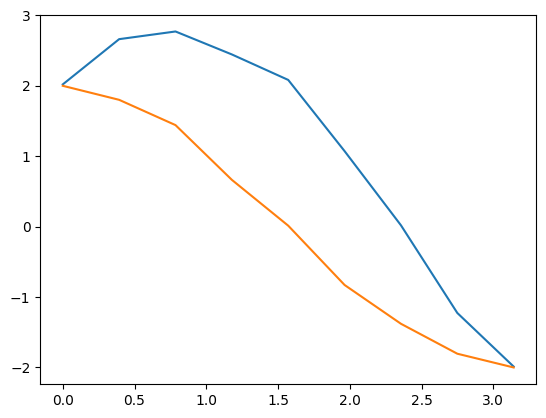

In [97]:
X = np.linspace(0, pi, 9)
plt.plot(X, S_quant)
plt.plot(X, S_LHV)
plt.show()

In [98]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman and Simon Cross.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.0
Numpy Version:      1.23.4
Scipy Version:      1.9.3
Cython Version:     None
Matplotlib Version: 3.6.1
Python Version:     3.11.0
Number of CPUs:     8
BLAS Info:          OPENBLAS
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Windows (AMD64)
Installation path:  c:\Users\nly99857\AppData\Local\Programs\Python\Python311\Lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily 